# General data reader for AQUA 

AQUA is built on different python classes, the `Reader` one being the cornerstone in order to provide a centralized common data access point in order to develop diagnostics. 

AQUA `Reader` uses `intake` catalogues from NextGEMS data, plus other observational datasets. It has been tested and developed on Levante, but it is has been tested also on MN4 and Lumi. An FDB direct access is currently developed, being transparent to the users.

On top of data access, the `Reader` includes also other functionalities: regridding, time and spatial averaging and metadata correction. Since streaming is not yet available, a streaming emulator has been introduced and can used to mimic streaming.

All these features can be used by the frontier diagnostics when they get real time data. Alternatively, some data have been included in the *Low Resolution Archive* (LRA), which is being built for each experiments and includes variable on monthly frequency, coarse grid and common metadata. State-of-the-art diagnostics can build on the LRA directly.

The idea of the regridder (which uses sparse matrix multiplication) is to generate first the weights for the interpolation (an operation which needs to be done only once) and then to use them for each regridding operation. For regridding to work you will need the external [smmregrid](https://github.com/jhardenberg/smmregrid) module in your environment.

The following notebooks illustrate more in detail different aspects of the functionality of the reader:

1. [Regridding](regrid.ipynb)
2. [Coordinate, variable name, units fixer](fixer.ipynb)
2. [Temporal averaging](timmean.ipynb)
3. [Spatial (field) averaging](fldmean.ipynb)
4. [Other datasets](datasets.ipynb)
5. [Streaming](streaming.ipynb)
6. [Accessor](accessor.ipynb)

## Basic functionality

In a nutshell, how to load ICON data, regrid them to a regular grid and plot a timeseries.

We start loading the module:

In [1]:
from aqua import Reader

Now let's load some ICON data. 

We first instantiate a `Reader` object specifying the type of data which we want to read from the catalogue. The `Reader` access is build on a 3-level hierarchy, made of `model`, `exp` and `source`. 

We also specify that we would like to regrid to a 0.1°x0.1° grid (`r100` for AQUA syntax). The first time (only then) when you run it, it will compute regridding weights for this particular source/destination grid combination. These will be stored in a directory specified in the `config/machines/<machine_name>/catalog.yaml` file. In this notebook we worked on levante, so the weights will be stored in `config/machines/levante/catalog.yaml`.

In [2]:
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid='r100', fix=False)

2023-12-07 19:08:10 :: Reader :: ERROR    -> Variable cfh_lnd has no units!
2023-12-07 19:08:10 :: Reader :: ERROR    -> Variable sic has no units!
2023-12-07 19:08:10 :: Reader :: ERROR    -> Variable sic has no units!


Later  the actual data can be read with the `retrieve` method. We have kept `fix=False` to access the data as they are. Please note that default is `fix=True`.

In [3]:
data = reader.retrieve()

2023-12-07 19:08:11 :: Reader :: ERROR    -> Variable cfh_lnd has no units!
2023-12-07 19:08:11 :: Reader :: ERROR    -> Variable sic has no units!
2023-12-07 19:08:11 :: Reader :: ERROR    -> Variable sic has no units!


The reader returns an `xarray.Dataset` with raw ICON data on the original grid.

In [4]:
data

<xarray.Dataset>
Dimensions:   (time: 37009, cell: 20971520)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20 ... 2022-03-01
Dimensions without coordinates: cell
Data variables: (12/34)
    cfh_lnd   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    clivi     (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cllvi     (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cptgzvi   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    hfls      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    hfss      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ...        ...
    tas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tauu      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tauv      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ts        (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    uas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    vas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 1522142023-12-07 19:08:10 retrie...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

Let's inspect the "tas" variable (in a DataArray)

In [5]:
data.tas

<xarray.DataArray 'tas' (time: 37009, cell: 20971520)>
dask.array<open_dataset-tas, shape=(37009, 20971520), dtype=float32, chunksize=(6, 1048576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T00:30:00 ... 2022-03-01
Dimensions without coordinates: cell
Attributes:
    CDI_grid_type:                unstructured
    cell_methods:                 t: point
    height:                       2.0 m
    long_name:                    temperature in 2m
    number_of_grid_in_reference:  1
    param:                        0.0.0
    standard_name:                tas
    units:                        K

A method to have some information about the reader setup is `info()`

In [6]:
reader.dst_grid_name

'r100'

In [7]:
reader.info()

Reader for model ICON, experiment ngc2009, source atm_2d_ml_R02B09
Regridding is active:
  Target grid is r100
  Regridding method is ycon
Metadata:
  source_grid_name: R02B09
  catalog_dir: /home/b/b382289/src/AQUA/config/machines/levante/catalog/ICON/
  dims: {'time': 37009, 'cell': 20971520}
  data_vars: {'cfh_lnd': ['time'], 'clivi': ['time'], 'cllvi': ['time'], 'cptgzvi': ['time'], 'hfls': ['time'], 'hfss': ['time'], 'pr': ['time'], 'prlr': ['time'], 'prw': ['time'], 'ps': ['time'], 'psl': ['time'], 'qgvi': ['time'], 'qrvi': ['time'], 'qsvi': ['time'], 'rlds': ['time'], 'rlus': ['time'], 'rlut': ['time'], 'rnds_dif': ['time'], 'rpds_dif': ['time'], 'rpds_dir': ['time'], 'rsds': ['time'], 'rsdt': ['time'], 'rsus': ['time'], 'rsut': ['time'], 'rvds_dif': ['time'], 'sfcwind': ['time'], 'sic': ['time'], 'sit': ['time'], 'tas': ['time'], 'tauu': ['time'], 'tauv': ['time'], 'ts': ['time'], 'uas': ['time'], 'vas': ['time']}
  coords: ('time',)
  CDI: Climate Data Interface version 1.8.3r

However, one of the possibility of the `Reader` is to have both ICON and IFS data on a common data format, namely grib-like, so that we can let `fix=True` and retrieve the data (please note that fixing will take care also of IFS cumulate fluxes)

In [8]:
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid='r100', fix=True)
data = reader.retrieve()

2023-12-07 19:08:16 :: Reader :: ERROR    -> Variable cfh_lnd has no units!
2023-12-07 19:08:16 :: Reader :: ERROR    -> Variable sic has no units!
2023-12-07 19:08:16 :: Reader :: ERROR    -> Variable sic has no units!
2023-12-07 19:08:16 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-12-07 19:08:16 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right
2023-12-07 19:08:16 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-12-07 19:08:16 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
2023-12-07 19:08:16 :: Reader :: ERROR    -> Variable cfh_lnd has no units!


Notice that these data are still on the original (irregular) grid. We can regrid (part of) them with:

In [9]:
tasr = reader.regrid(data['2t'][10, :])
tasr

<xarray.DataArray '2t' (lat: 180, lon: 360)>
dask.array<reshape, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2020-01-20T05:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    cell_methods:                 t: point
    height:                       2.0 m
    long_name:                    2 metre temperature
    number_of_grid_in_reference:  1
    param:                        0.0.0
    standard_name:                tas
    units:                        K
    history:                      2023-12-07 19:08:16 variable renamed by AQU...
    paramId:                      167
    cfVarName:                    t2m
    shortName:                    2t
    regridded:                    1

and finally plot them:

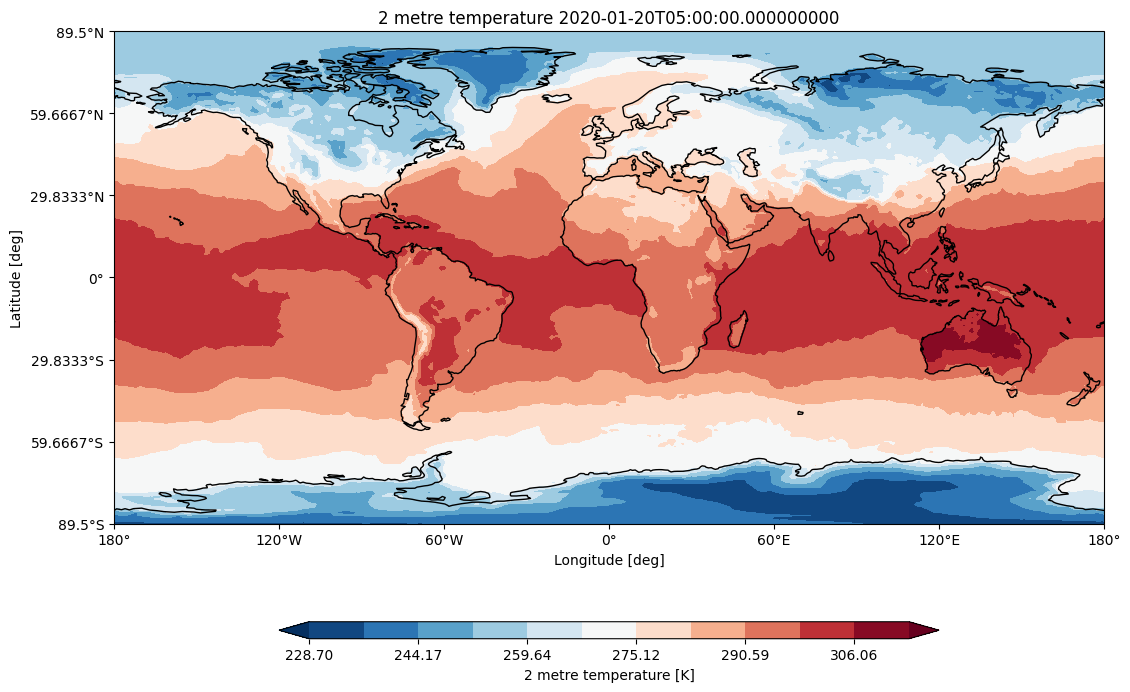

In [10]:
from aqua import plot_single_map
plot_single_map(tasr)

We can also plot a timeseries using the `fldmean` method, which performs a spatial average over the whole domain.

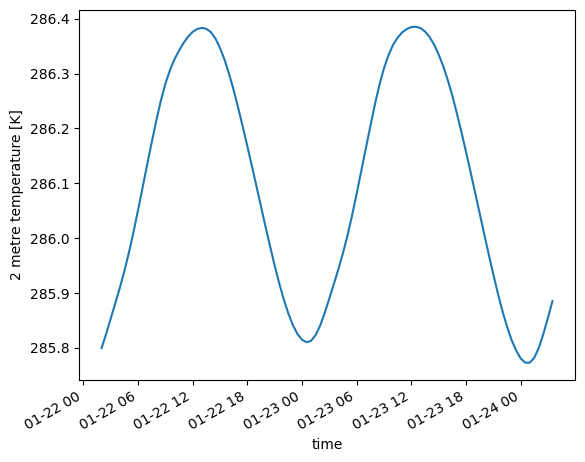

In [11]:
global_mean = reader.fldmean(data['2t'][100:200, :])
global_mean.plot()

Modifying the `Reader` 3-level hierarchy, we can also access directly data from the LRA, in this case below for FESOM.

In [12]:
reader = Reader(model="FESOM", exp="tco2559-ng5", source="lra-r100-monthly", fix=False)
data = reader.retrieve()
data

<xarray.Dataset>
Dimensions:  (time: 12, lat: 180, lon: 360, nz1: 69)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-02-01 ... 2020-12-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * nz1      (nz1) float64 2.5 7.5 12.5 17.5 ... 5.525e+03 5.825e+03 6.175e+03
Data variables:
    ci       (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    ocpt     (time, nz1, lat, lon) float64 dask.array<chunksize=(12, 69, 180, 360), meta=np.ndarray>
    sithick  (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    so       (time, nz1, lat, lon) float64 dask.array<chunksize=(12, 69, 180, 360), meta=np.ndarray>
    sos      (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sst      (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    zos      (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    history:  2023-12-07 19:08:42 retrieved by AQUA retriever;\n2023-12-07 19...

We can easily plot the sst for February 2020

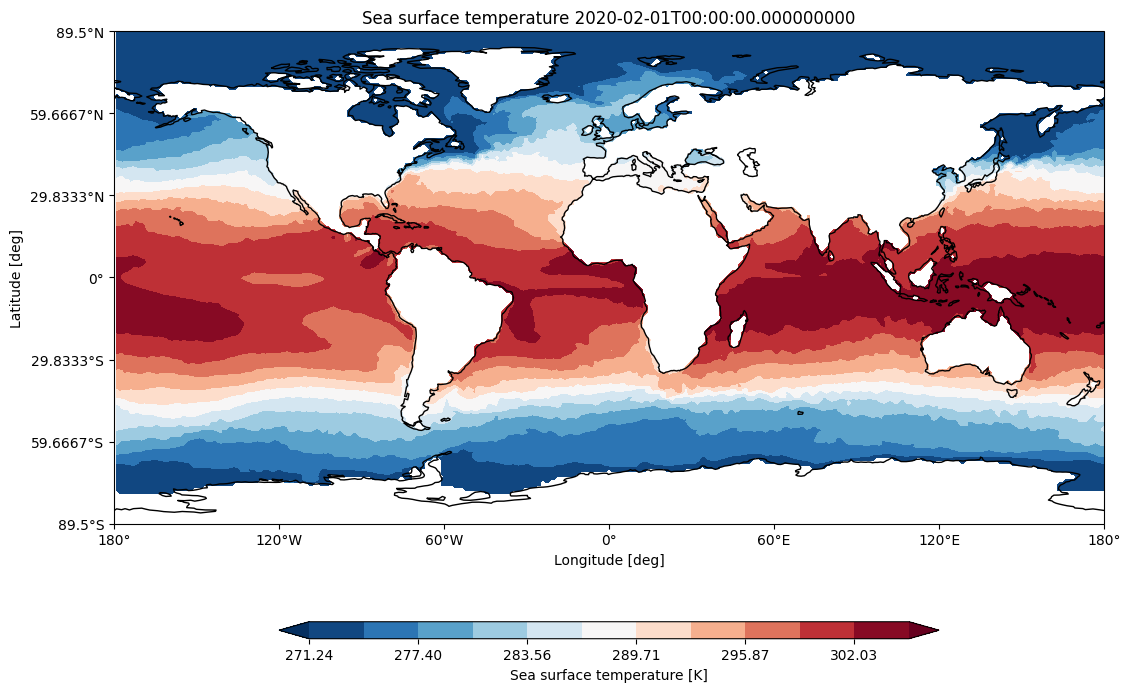

In [15]:
plot_single_map(data['sst'][1,:,:], transform_first=True)

## Extra notes

### Dask

It is convenient to start a Dask cluster first (unless you already are working on a Levante jupyter hub) and to connect to it

In [12]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(ip="0.0.0.0", threads_per_worker=2, n_workers=16)
client = Client(cluster)  # memory_limit='64GB'
cluster

LocalCluster(69176639, 'tcp://136.172.124.1:44865', workers=16, threads=32, memory=501.94 GiB)

The cluster can then be closed at the end of the notebook with:

In [13]:
cluster.close()

### Catalogue

In order to check what is available in the catalogue there is the `catalogue()` function. It returns the catalogue itself by default, that's why we use it with a semicolon at the end.

In [14]:
from aqua import catalogue
catalogue();

IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-monthly	LRA data monthly at r100
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-monthly	LRA data monthly at r100
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- lra-r100-monthly	LRA data monthly at r100
IFS	tco2559-ng5-cycle3	main 4.4km Cycle 3 experiment, coupled with FESOM 5km
	- 2D_1h_native	
	- 3D_1h_native	
	- 2D_monthly_0.25deg	
	- 3D_monthly_0.25deg	
	- lra-r100-monthly	LRA data monthly at

The data are classified in "models" (e.g. ICON, IFS etc.). Each model has a different "experiment" and there are different "sources" for each of them. 

A note on configuration files: by default the reader looks for its config files in this list of folders:

- `$AQUA`
- `./../../AQUA/config`
- `./config`
- `../config`
- `../../config`
- `../../../config`
- `$HOME/.aqua/config`

where `$AQUA` is the environment variable pointing to the AQUA folder if the user has it defined.